In [1]:
import sys
import tensorflow as tf
import random
import numpy as np
tf.reset_default_graph()

def in_ipynb():
    try:
        cfg = get_ipython().config
        print(cfg)
        if 'jupyter' in cfg['IPKernelApp']['connection_file']:
            return True
        else:
            return False
    except NameError:
        return False

if in_ipynb():
    print("In IPython")
    exec("import Configs.MultiClassSampleConfig as Conf")
    TrainConfig="Configs/MultiClassSampleConfig"
else:
    TrainConfig=sys.argv[1]
    print("Importing settings from "+ TrainConfig.replace("/", "."))
    #exec("from "+TrainConfig+" import *")
    importConfig=TrainConfig.replace("/", ".")
    exec("import "+importConfig+" as Conf")

/home/akapoor/miniconda3/envs/forEGammaSFs/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/akapoor/miniconda3/envs/forEGammaSFs/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/akapoor/miniconda3/envs/forEGammaSFs/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/akapoor/minicond

{'IPKernelApp': {'connection_file': '/home/akapoor/.local/share/jupyter/runtime/kernel-2e6d2df1-f001-42fa-b3d6-5e65e96caf9c.json'}}
In IPython
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/home/akapoor/miniconda3/envs/forEGammaSFs/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/akapoor/miniconda3/envs/forEGammaSFs/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/akapoor/miniconda3/envs/forEGammaSFs/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
if not hasattr(Conf, 'MVAlogplot'): Conf.MVAlogplot=False
if not hasattr(Conf, 'Multicore'): Conf.Multicore=False
if not hasattr(Conf, 'RandomState'): Conf.RandomState=42

In [3]:

tf.compat.v1.random.set_random_seed(Conf.RandomState)
random.seed(Conf.RandomState)
np.random.seed(Conf.RandomState)

In [4]:
import os
os.system("")
try:
  import uproot3 as uproot
except ImportError:
  import uproot

In [5]:
import glob
import pandas as pd
import numpy as np
import ROOT
import matplotlib.pyplot as plt
import json

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

Welcome to JupyROOT 6.24/00


In [6]:
from Tools.PlotTools import *
import Tools.ptetaRwt as ptetaRwt

In [7]:

if Conf.Debug==True:
    prGreen("Running in debug mode : Only every 10th event will be used")
    
if len(Conf.MVAs)>0:
    for MVAd in Conf.MVAs:
        os.system("mkdir -p " + Conf.OutputDirName+"/"+MVAd["MVAtype"])
prGreen("Making output directory")
os.system("mkdir -p " + Conf.OutputDirName)
os.system("mkdir -p " + Conf.OutputDirName+"/CodeANDConfig")
os.system("mkdir -p " + Conf.OutputDirName+"/Thresholds")
os.system("cp "+TrainConfig+".py ./"+ Conf.OutputDirName+"/CodeANDConfig/")
os.system("cp Trainer.py ./"+ Conf.OutputDirName+"/CodeANDConfig/")    

 Running in debug mode : Only every 10th event will be used
 Making output directory


0

In [8]:
cat='Category'
weight='NewWt'


In [9]:
label=Conf.Classes

In [10]:
#Works in uproot3
prGreen("Making data frames")
Sigdf=pd.DataFrame()
Bkgdf=pd.DataFrame()

 Making data frames


In [11]:
import Tools.readData as readData
import sys
import os

In [12]:
import pandas as pd
if Conf.loadfromsaved:
    df_final=pd.read_parquet(Conf.OutputDirName+'/df.parquet.gzip')
else:
    df_final=readData.daskframe_from_rootfiles(Conf.processes,Conf.Tree,branches=Conf.branches,flatten=Conf.flatten,debug=Conf.Debug)
    if hasattr(Conf, 'SaveDataFrameCSV'): 
        if Conf.SaveDataFrameCSV:
            prGreen("Saving DataFrame : It can take sometime")
            df_final.to_parquet(Conf.OutputDirName+'/df.parquet.gzip',compression='gzip')

Getting data from DYJetsToLL_M-50_v7_ElePromptGenMatched.root
Getting data from DYJetsToLL_M-50_v7_ElePromptGenMatched.root
Getting data from DYJetsToLL_M-50_v7_ElePromptGenMatched.root
Getting data from DYJetsToLL_M-50_v7_ElePromptGenMatched.root
 Saving DataFrame : It can take sometime


In [13]:
fn = lambda row: Conf.Classes.index(row.Class)
df_final[cat] = df_final.apply(fn, axis=1)

In [14]:
#df_final.head()
Conf.modfiydf(df_final)
#Conf.modfiydf(Bkgdf)

0

In [15]:
#SigIndices=df_final.query("sample=='Signal'").index.values.tolist()
#BkgIndices=df_final.query("sample=='Background'").index.values.tolist()
index = df_final.index
Classes=Conf.Classes

from sklearn.model_selection import train_test_split

TrainIndices=[]
TestIndices=[]

for myclass in Classes:
    condition = df_final["Class"] == myclass
    Indices = index[condition].values.tolist()
    myclassTrainIndices, myclassTestIndices = train_test_split(Indices, test_size=Conf.testsize, random_state=Conf.RandomState, shuffle=True)
    TrainIndices=TrainIndices + myclassTrainIndices
    TestIndices=TestIndices + myclassTestIndices

In [16]:
df_final.loc[TrainIndices,'Dataset'] = "Train"
df_final.loc[TestIndices,'Dataset'] = "Test"

df_final.loc[TrainIndices,'TrainDataset'] = 1
df_final.loc[TestIndices,'TrainDataset'] = 0

In [17]:
df_final.Class.unique().tolist()

['Class1', 'Class2', 'Class3']

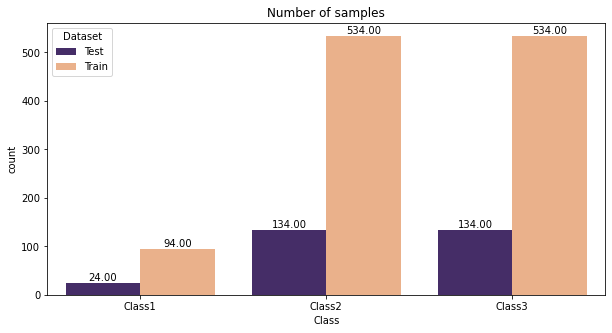

In [18]:
import seaborn as sns
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
kplot=sns.countplot(x="Class", data=df_final, ax=axes,hue='Dataset',palette=['#432371',"#FAAE7B","black"])
for p in kplot.patches:
    kplot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
axes.set_title("Number of samples")
#axes.set_yscale("log")
plt.savefig(Conf.OutputDirName+"/TotalStat_TrainANDTest.pdf")
plt.savefig(Conf.OutputDirName+"/TotalStat_TrainANDTest.png")

In [19]:
def df_pteta_rwt(Mdf,
                 label,
                 returnOnlyPosWeights=0, 
                 ptw = [10,30,40,50,200,10000], 
                 etaw = [-1.5,-1.0,1.0,1.5], 
                 eta='', 
                 pt='',
                 SumWeightCol="wt",
                 NewWeightCol="NewWt",cand="",
                 Classes=[""]):
    Mdf["rwt"]=1
    Mdf[NewWeightCol]=1
    ptwt = [1.0]*len(ptw)
    etawt = [1.0]*len(etaw)
    
    for k in range(len(etaw)):
        if k == len(etaw)-1:
            continue
        for i in range(len(ptw)):
            if i == len(ptw)-1:
                continue
            for target in Classes:
                if target != cand:
                    targetSum = Mdf.loc[(Mdf[pt] <ptw[i+1]) & (Mdf[pt] >ptw[i]) 
                                        & (Mdf[eta] <etaw[k+1]) & (Mdf[eta] >etaw[k]) 
                                        &(Mdf[label]==target),SumWeightCol].sum()
                    candSum = Mdf.loc[(Mdf[pt] <ptw[i+1]) & (Mdf[pt] >ptw[i]) 
                                      & (Mdf[eta] <etaw[k+1]) & (Mdf[eta] >etaw[k]) 
                                      &(Mdf[label]==cand),SumWeightCol].sum()

                    #print('Number of xsec events in signal for pt '+str(ptw[i])+' to '+str(ptw[i+1])+ 'before  weighing = '+str(targetSum))
                    #print('Number of xsec events in background for pt '+str(ptw[i])+' to '+str(ptw[i+1])+ 'before  weighing = '+str(candSum))

                    if candSum>0 and targetSum>0:
                        ptwt[i]=candSum/(targetSum)
                    else:
                        ptwt[i]=0
                    
                    Mdf.loc[(Mdf[pt] <ptw[i+1]) & (Mdf[pt] >ptw[i]) 
                            & (Mdf[eta] <etaw[k+1]) & (Mdf[eta] >etaw[k]) 
                            &(Mdf[label]==cand),"rwt"] = 1.0
                    Mdf.loc[(Mdf[pt] <ptw[i+1]) & (Mdf[pt] >ptw[i]) 
                            & (Mdf[eta] <etaw[k+1]) & (Mdf[eta] >etaw[k]) 
                            &(Mdf[label]==target),"rwt"] = ptwt[i]

    Mdf.loc[:,NewWeightCol] = Mdf.loc[:,"rwt"]*Mdf.loc[:,SumWeightCol]
    
    for justclass in Classes:
        Sum = Mdf.loc[Mdf[label]==justclass,NewWeightCol].sum()
        print(f'Number of events in {justclass} after  weighing = '+str(Sum))

    return Mdf[NewWeightCol]
    

In [20]:
df_final[weight]=1

ReweightClass=Conf.WhichClassToReweightTo

In [21]:
print("In Training:")
if Conf.Reweighing=='True':
    df_final.loc[TrainIndices,weight]=df_pteta_rwt(df_final.loc[TrainIndices],"Class",
                                                   ptw=Conf.ptbins,etaw=Conf.etabins,
                                                   pt=Conf.ptwtvar,eta=Conf.etawtvar,
                                                   SumWeightCol='xsecwt',NewWeightCol=weight, 
                                                   cand=ReweightClass,Classes=Conf.Classes)

In Training:
Number of events in Class1 after  weighing = 94.0
Number of events in Class2 after  weighing = 93.0
Number of events in Class3 after  weighing = 93.0


In [22]:
print("In Testing:")
if Conf.Reweighing=='True':
    df_final.loc[TestIndices,weight]=df_pteta_rwt(df_final.loc[TestIndices],"Class",
                                                  ptw=Conf.ptbins,etaw=Conf.etabins,
                                                  pt=Conf.ptwtvar,eta=Conf.etawtvar,
                                                  SumWeightCol='xsecwt',NewWeightCol=weight, 
                                                  cand=ReweightClass,Classes=Conf.Classes)            

In Testing:
Number of events in Class1 after  weighing = 24.0
Number of events in Class2 after  weighing = 24.0
Number of events in Class3 after  weighing = 24.0


In [23]:
#df_final["ele_pt_bin"]=-9
#df_final["ele_eta_bin"]=-9
if Conf.Reweighing=='True':
    df_final["ele_pt_bin"] = pd.cut(df_final[Conf.ptwtvar], bins=Conf.ptbins, labels=list(range(len(Conf.ptbins)-1)))
    df_final["ele_eta_bin"] = pd.cut(df_final[Conf.etawtvar], bins=Conf.etabins, labels=list(range(len(Conf.etabins)-1)))
    

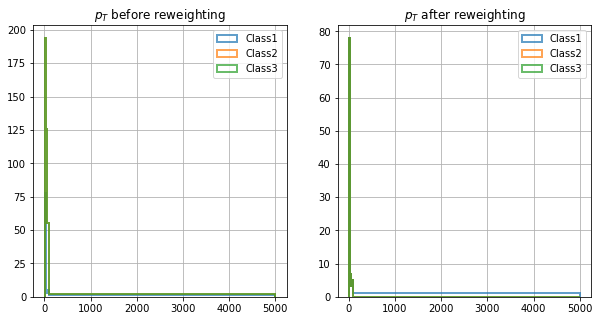

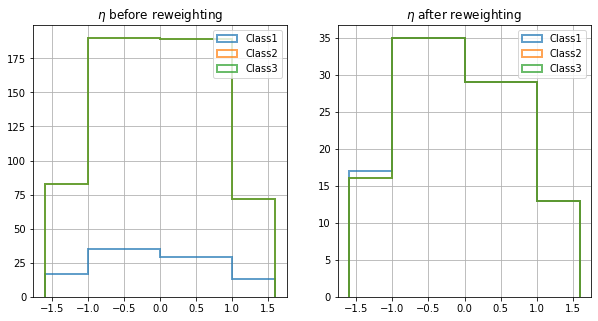

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i,group_df in df_final[df_final['Dataset'] == "Train"].groupby("Class"):
    group_df[Conf.ptwtvar].hist(histtype='step', bins=Conf.ptbins, alpha=0.7,label=i, ax=ax[0], density=False, ls='-', weights =group_df["xsecwt"],linewidth=2)
    ax[0].set_title("$p_T$ before reweighting")
    ax[0].legend()
    group_df[Conf.ptwtvar].hist(histtype='step', bins=Conf.ptbins, alpha=0.7,label=i, ax=ax[1], density=False, ls='-', weights =group_df["NewWt"],linewidth=2)
    ax[1].set_title("$p_T$ after reweighting")
    ax[1].legend()
fig.savefig(Conf.OutputDirName+"/pT_rwt.pdf")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i,group_df in df_final[df_final['Dataset'] == "Train"].groupby("Class"):
    group_df[Conf.etawtvar].hist(histtype='step', 
                                 bins=Conf.etabins,
                                 #[i for i in range(len(Conf.etabins)-1)], 
                                 alpha=0.7,label=i, ax=ax[0], density=False, ls='-', weights =group_df["xsecwt"],linewidth=2)
    ax[0].set_title("$\eta$ before reweighting")
    ax[0].legend()
    group_df[Conf.etawtvar].hist(histtype='step', 
                                 bins=Conf.etabins,
                                 alpha=0.7,label=i, ax=ax[1], density=False, ls='-', weights =group_df["NewWt"],linewidth=2)
    ax[1].set_title("$\eta$ after reweighting")
    ax[1].legend()
fig.savefig(Conf.OutputDirName+"/eta_rwt.pdf")
    

In [25]:
'''
fig, axee = plt.subplots(2, 2, figsize=(30, 10))
for i in [0,1]:
    axe=axee[0][i]
    sns.histplot(data=df_final.loc[TrainIndices].query("EleType==@i"), x="ele_eta_bin", y="ele_pt_bin",ax=axe,bins=40,
                 element="bars", fill=False,cbar=False,
                 weights="xsecwt")
    axe.set_title(label[i]+" before reweighting")
    
    axe=axee[1][i]
    sns.histplot(data=df_final.loc[TrainIndices].query("EleType==@i"), x="ele_eta_bin", y="ele_pt_bin",ax=axe,bins=40,
                 element="bars", fill=False,cbar=False,
                 weights="NewWt")
    axe.set_title(label[i]+" after reweighting")

fig.savefig(Conf.OutputDirName+"/eta_pt_rwt.pdf")
'''

'\nfig, axee = plt.subplots(2, 2, figsize=(30, 10))\nfor i in [0,1]:\n    axe=axee[0][i]\n    sns.histplot(data=df_final.loc[TrainIndices].query("EleType==@i"), x="ele_eta_bin", y="ele_pt_bin",ax=axe,bins=40,\n                 element="bars", fill=False,cbar=False,\n                 weights="xsecwt")\n    axe.set_title(label[i]+" before reweighting")\n    \n    axe=axee[1][i]\n    sns.histplot(data=df_final.loc[TrainIndices].query("EleType==@i"), x="ele_eta_bin", y="ele_pt_bin",ax=axe,bins=40,\n                 element="bars", fill=False,cbar=False,\n                 weights="NewWt")\n    axe.set_title(label[i]+" after reweighting")\n\nfig.savefig(Conf.OutputDirName+"/eta_pt_rwt.pdf")\n'

In [26]:
def PrepDataset(df_final,TrainIndices,TestIndices,features,cat,weight):
    X_train = df_final.loc[TrainIndices,features]
    Y_train = df_final.loc[TrainIndices,cat]
    Wt_train = df_final.loc[TrainIndices,weight]
    
    X_test = df_final.loc[TestIndices,features]
    Y_test = df_final.loc[TestIndices,cat]
    Wt_test = df_final.loc[TestIndices,weight]
    return np.asarray(X_train), np.asarray(Y_train), np.asarray(Wt_train), np.asarray(X_test), np.asarray(Y_test), np.asarray(Wt_test)

In [27]:
import pickle
import multiprocessing

In [28]:
for MVA in Conf.MVAs:
    if 'XGB' in MVA["MVAtype"]:
        if len(Conf.Classes)>2:
            print(f"{MVA['MVAtype']}: Sorry, at the moment XGBoost implementation does not support more than two classes!")
            print(f"{MVA['MVAtype']}: If you really need multi-class classification, you can use a DNN")
            continue
        MakeFeaturePlots(df_final,MVA["features"],MVA["feature_bins"],Set="Train",MVA=MVA["MVAtype"],OutputDirName=Conf.OutputDirName,label=Conf.Classes)
        MakeFeaturePlots(df_final,MVA["features"],MVA["feature_bins"],Set="Test",MVA=MVA["MVAtype"],OutputDirName=Conf.OutputDirName,label=Conf.Classes)
        MakeFeaturePlotsComb(df_final,MVA["features"],MVA["feature_bins"],MVA=MVA["MVAtype"],OutputDirName=Conf.OutputDirName,label=Conf.Classes)
        X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(df_final,TrainIndices,TestIndices,MVA["features"],cat,weight)
        prGreen(MVA["MVAtype"]+" Applying "+MVA["Scaler"])
        exec("from sklearn.preprocessing import "+MVA["Scaler"])
        exec("sc = "+MVA["Scaler"]+"()")
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        prGreen(MVA["MVAtype"]+" Training starting")
        import xgboost as xgb
        from sklearn.model_selection import cross_val_score, GridSearchCV
        xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=Conf.RandomState)
        #xgb_model.set_config(verbosity=2)
        prGreen("Performing XGB grid search")
        if Conf.Multicore:
            cv = GridSearchCV(xgb_model, MVA["XGBGridSearch"],
                              scoring='neg_log_loss',cv=3,verbose=1,n_jobs=2)#multiprocessing.cpu_count())
        else:
            cv = GridSearchCV(xgb_model, MVA["XGBGridSearch"],
                              scoring='neg_log_loss',cv=3,verbose=1)
        search=cv.fit(X_train, Y_train, sample_weight=Wt_train,verbose=1)
        pickle.dump(cv, open(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"modelXGB.pkl", "wb"))
        #modelDNN.save(Conf.OutputDirName+"/"+MVA+"_"+"modelDNN.h5")
        prGreen("Expected neg log loss of XGB model = "+str((np.round(np.average(search.best_score_),3))*100)+'%')
        #prGreen("Expected accuracy of XGB model = "+str((np.average(search.best_score_))*100)+'%')
        prGreen("XGB Best Parameters")
    
        #json.dumps(search.best_params_)
        prGreen(str(search.best_params_))
    
        df_final.loc[TrainIndices,MVA["MVAtype"]+"_pred"]=cv.predict_proba(X_train)[:,1]
        df_final.loc[TestIndices,MVA["MVAtype"]+"_pred"]=cv.predict_proba(X_test)[:,1]
    
        prGreen("Plotting output response for XGB")
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        plot_mva(df_final.query('TrainDataset==1'),MVA["MVAtype"]+"_pred",bins=50,cat="Class",Wt=weight,ax=axes,sample='train',ls='dashed',logscale=Conf.MVAlogplot,label=Conf.Classes)
        plot_mva(df_final.query('TrainDataset==0'),MVA["MVAtype"]+"_pred",bins=50,cat="Class",Wt=weight,ax=axes,sample='test',ls='dotted',logscale=Conf.MVAlogplot,label=Conf.Classes)
        plt.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"XGBMVA.pdf")
        plt.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"XGBMVA.png")
    
        prGreen("Plotting ROC for XGB")
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        if len(Conf.Classes)<=2:
            plot_roc_curve(df_final.query('TrainDataset==1'),MVA["MVAtype"]+"_pred", tpr_threshold=0, ax=axes, color=None, linestyle='-', label=MVA["Label"]+' Training',cat=cat,Wt=weight)
            plot_roc_curve(df_final.query('TrainDataset==0'),MVA["MVAtype"]+"_pred", tpr_threshold=0, ax=axes, color=None, linestyle='--', label=MVA["Label"]+' Testing',cat=cat,Wt=weight)
            if len(Conf.OverlayWP)>0:
                for color,OverlayWpi in zip(Conf.OverlayWPColors,Conf.OverlayWP):
                    plot_single_roc_point(df_final.query('TrainDataset==0'), var=OverlayWpi, ax=axes, color=color, marker='o', markersize=6, label=OverlayWpi+" Test dataset", cat=cat,Wt=weight)
            axes.set_ylabel("Background efficiency")
            axes.set_xlabel("Signal efficiency")
            axes.set_title(MVA["MVAtype"])
            axes.text(1.05, 0.5, 'CMS EGamma ID-Trainer',
                      horizontalalignment='center',
                      verticalalignment='center',
                      rotation='vertical',
                      transform=axes.transAxes)
            plt.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"XGBROC.pdf")
            plt.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"XGBROC.png")

XGB_1: Sorry, at the moment XGBoost implementation does not support more than two classes!
XGB_1: If you really need multi-class classification, you can use a DNN
XGB_2: Sorry, at the moment XGBoost implementation does not support more than two classes!
XGB_2: If you really need multi-class classification, you can use a DNN


 MakingTrain dataset feature plots
 MakingTest dataset feature plots
 Making Combined dataset feature plots
(1162, 3)
 DNN_1 Applying MinMaxScaler
 DNN fitting running
Settings early stopping
Train on 1162 samples, validate on 292 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
1162/1162 [==============================] - 0s 158us/sample - loss: 0.5448 - acc: 0.6667 - val_loss: 0.4742 - val_acc: 0.6667
Epoch 2/10
1162/1162 [==============================] - 0s 24us/sample - loss: 0.4640 - acc: 0.6667 - val_loss: 0.4094 - val_acc: 0.6667
Epoch 3/10
1162/1162 [==============================] - 0s 21us/sample - loss: 0.3540 - acc: 0.6667 - val_loss: 0.1863 - val_acc: 0.6667
Epoch 4/10
1162/1162 [==============================] - 0s 22us/sample - loss: 0.1855 - acc: 0.6670 - val_loss: 0.1644 - val_acc: 0.6667
Epoch 5/10
1162/1162 [==============================] - 0s 23us/sample - loss: 0.1632 - acc: 0.6661 - val_loss: 0.1603

'\n        prGreen("Plotting output response for DNN")\n        fig, axes = plt.subplots(1, 1, figsize=(5, 5))\n        plot_mva(df_final.query(\'TrainDataset==1\'),MVA["MVAtype"]+"_pred",bins=50,cat=cat,Wt=weight,ax=axes,sample=\'train\',ls=\'dashed\',logscale=Conf.MVAlogplot)\n        plot_mva(df_final.query(\'TrainDataset==0\'),MVA["MVAtype"]+"_pred",bins=50,cat=cat,Wt=weight,ax=axes,sample=\'test\',ls=\'dotted\',logscale=Conf.MVAlogplot)\n        plt.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"DNNMVA.pdf")\n        plt.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"DNNMVA.png")\n    \n        prGreen("Plotting ROC for DNN")\n        fig, axes = plt.subplots(1, 1, figsize=(5, 5))\n        plot_roc_curve(df_final.query(\'TrainDataset==1\'),MVA["MVAtype"]+"_pred", tpr_threshold=0, ax=axes, color=None, linestyle=\'-\', label=MVA["Label"]+\' Training\',cat=cat,Wt=weight)\n        plot_roc_curve(df_final.query(\'TrainDataset==0\'),MVA["MVA

2021-07-08 18:34:10.774713: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-07-08 18:34:10.784960: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3193875000 Hz
2021-07-08 18:34:10.787708: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c8bdf6c620 executing computations on platform Host. Devices:
2021-07-08 18:34:10.787746: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2021-07-08 18:34:10.832455: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not 

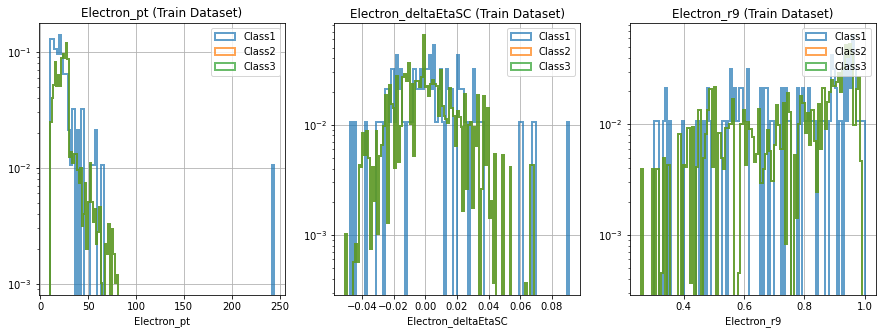

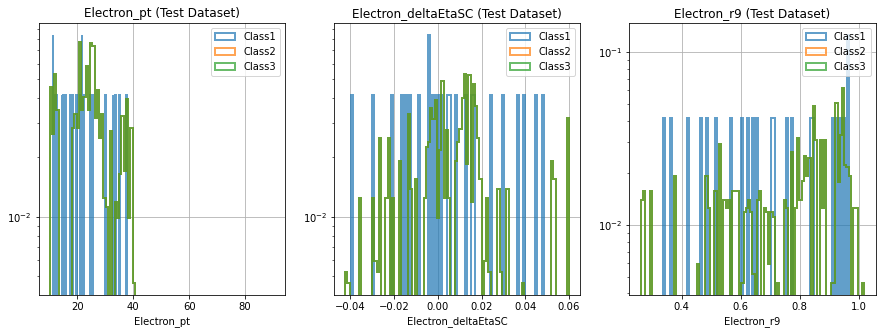

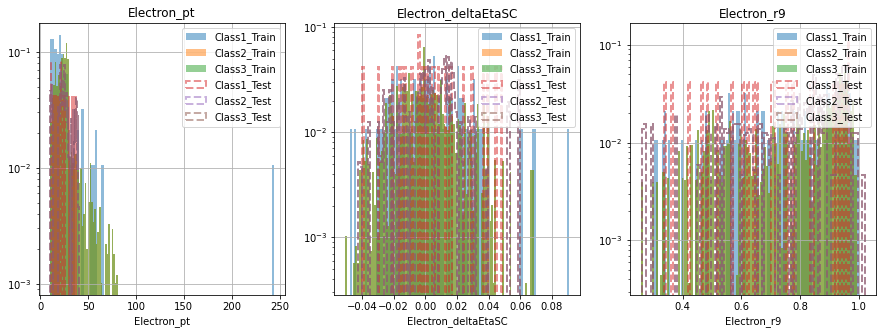

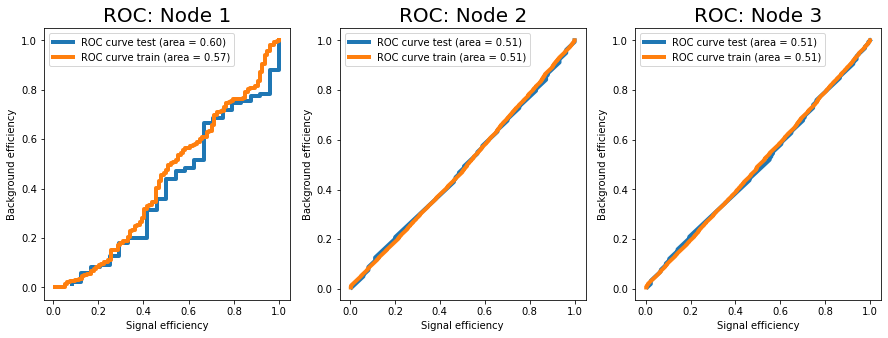

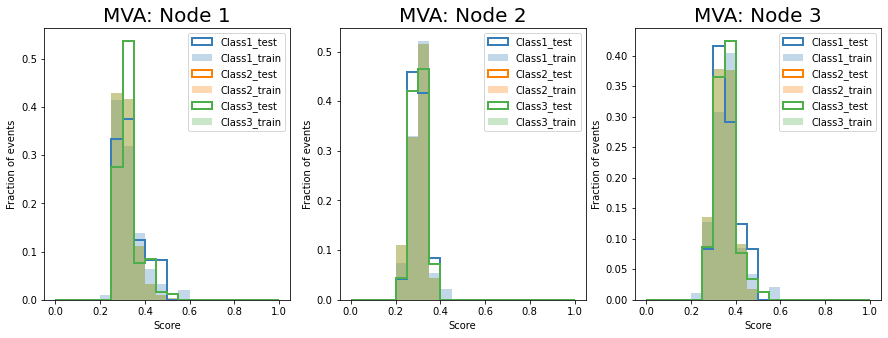

In [29]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
for MVA in Conf.MVAs:
    if 'DNN' in MVA["MVAtype"]:
        MakeFeaturePlots(df_final,MVA["features"],MVA["feature_bins"],Set="Train",MVA=MVA["MVAtype"],OutputDirName=Conf.OutputDirName,label=Conf.Classes)
        MakeFeaturePlots(df_final,MVA["features"],MVA["feature_bins"],Set="Test",MVA=MVA["MVAtype"],OutputDirName=Conf.OutputDirName,label=Conf.Classes)
        MakeFeaturePlotsComb(df_final,MVA["features"],MVA["feature_bins"],MVA=MVA["MVAtype"],OutputDirName=Conf.OutputDirName,label=Conf.Classes)
        X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(df_final,TrainIndices,TestIndices,MVA["features"],cat,weight)
        Y_train = to_categorical(Y_train, num_classes=len(Conf.Classes))
        Y_test = to_categorical(Y_test, num_classes=len(Conf.Classes))
        print(Y_train.shape)
        prGreen(MVA["MVAtype"]+" Applying "+MVA["Scaler"])
        exec("from sklearn.preprocessing import "+MVA["Scaler"])
        exec("sc = "+MVA["Scaler"]+"()")
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        prGreen("DNN fitting running")
        
        #es=['']
        #if hasattr(Conf, 'MVA["DNNDict"]['earlyStopping']'):
        try:
            es = MVA["DNNDict"]['earlyStopping']
            print("Settings early stopping")
        except KeyError:
            es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
            print("No early stopping specified, will use the default one")
        #es = MVA["DNNDict"]['earlyStopping']
        modelDNN=MVA["DNNDict"]['model']
        modelDNN.compile(loss=MVA["DNNDict"]['compile']['loss'], optimizer=MVA["DNNDict"]['compile']['optimizer'], metrics=MVA["DNNDict"]['compile']['metrics'])
        train_history = modelDNN.fit(X_train,Y_train,epochs=MVA["DNNDict"]['epochs'],batch_size=MVA["DNNDict"]['batchsize'],validation_data=(X_test,Y_test, Wt_test),
                                     verbose=1,callbacks=[es], sample_weight=Wt_train)
        modelDNN.save(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"modelDNN.h5")
        
        y_train_pred=np.array(modelDNN.predict(X_train,batch_size=5000)) #This is not the training batch size
        y_test_pred=np.array(modelDNN.predict(X_test,batch_size=5000)) #This is not the training batch size
        #https://anshulhep.medium.com/make-your-tensorflow-keras-predictions-faster-with-batch-size-8bbd780b9c08
        
        from sklearn.metrics import roc_curve, auc

        n_classes=len(Conf.Classes)
        fig, axes = plt.subplots(1, n_classes, figsize=(n_classes*5, 5))
        figMVA, axesMVA = plt.subplots(1, n_classes, figsize=(n_classes*5, 5))
        
        for i in range(n_classes):
            axMVA=axesMVA[i]
            ax=axes[i]
            for k in range(n_classes):
                axMVA.hist(y_test_pred[:, i][Y_test[:, k]==1],bins=np.linspace(0, 1, 21),label=Conf.Classes[k]+'_test',
                           weights=Wt_test[Y_test[:, k]==1]/np.sum(Wt_test[Y_test[:, k]==1]),
                           histtype='step',linewidth=2,color=Conf.ClassColors[k])
                axMVA.hist(y_train_pred[:, i][Y_train[:, k]==1],bins=np.linspace(0, 1, 21),label=Conf.Classes[k]+'_train',
                           weights=Wt_train[Y_train[:, k]==1]/np.sum(Wt_train[Y_train[:, k]==1]),
                           histtype='stepfilled',alpha=0.3,linewidth=2,color=Conf.ClassColors[k])
            axMVA.set_title(MVA["MVAtype"]+' Score: Node '+str(i+1),fontsize=10)
            axMVA.set_xlabel('Score',fontsize=10)
            axMVA.set_ylabel('Fraction of events',fontsize=10)
            axMVA.legend(loc="upper right",fontsize=10)
            if Conf.MVAlogplot:
                axMVA.set_xscale('log')
            
            fpr, tpr, th = roc_curve(Y_test[:, i], y_test_pred[:, i])
            fpr_tr, tpr_tr, th_tr = roc_curve(Y_train[:, i], y_train_pred[:, i])
            mask = tpr > 0.0
            fpr, tpr = fpr[mask], tpr[mask]

            mask = tpr_tr > 0.0
            fpr_tr, tpr_tr = fpr_tr[mask], tpr_tr[mask]

            roc_auc = auc(fpr, tpr)
            roc_auc_tr = auc(fpr_tr, tpr_tr)

            ax.plot(tpr, fpr, label='ROC curve test (area = %0.2f)' % roc_auc,linewidth=1)
            ax.plot(tpr_tr, fpr_tr, label='ROC curve train (area = %0.2f)' % roc_auc_tr,linewidth=1)
            #plt.plot([0, 1], [0, 1], 'k--')
            #ax.set_xlim([0.8, 1.0])
            #ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('Signal efficiency',fontsize=10)
            ax.set_ylabel('Background efficiency',fontsize=10)
            ax.set_title(MVA["MVAtype"]+' ROC: Node '+str(i+1),fontsize=10)
            ax.legend(loc="upper left",fontsize=10)
        fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"DNNROC.pdf")
        fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"DNNROC.png")
        figMVA.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"DNNMVA.pdf")
        figMVA.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"DNNMVA.png")
    
        if len(Conf.Classes)<=2:
            df_final.loc[TrainIndices,MVA["MVAtype"]+"_pred"]=modelDNN.predict(X_train)[:,1]
            df_final.loc[TestIndices,MVA["MVAtype"]+"_pred"]=modelDNN.predict(X_test)[:,1]

'''
        prGreen("Plotting output response for DNN")
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        plot_mva(df_final.query('TrainDataset==1'),MVA["MVAtype"]+"_pred",bins=50,cat=cat,Wt=weight,ax=axes,sample='train',ls='dashed',logscale=Conf.MVAlogplot)
        plot_mva(df_final.query('TrainDataset==0'),MVA["MVAtype"]+"_pred",bins=50,cat=cat,Wt=weight,ax=axes,sample='test',ls='dotted',logscale=Conf.MVAlogplot)
        plt.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"DNNMVA.pdf")
        plt.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"DNNMVA.png")
    
        prGreen("Plotting ROC for DNN")
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        plot_roc_curve(df_final.query('TrainDataset==1'),MVA["MVAtype"]+"_pred", tpr_threshold=0, ax=axes, color=None, linestyle='-', label=MVA["Label"]+' Training',cat=cat,Wt=weight)
        plot_roc_curve(df_final.query('TrainDataset==0'),MVA["MVAtype"]+"_pred", tpr_threshold=0, ax=axes, color=None, linestyle='--', label=MVA["Label"]+' Testing',cat=cat,Wt=weight)
        if len(Conf.OverlayWP)>0:
            for color,OverlayWpi in zip(Conf.OverlayWPColors,Conf.OverlayWP):
                plot_single_roc_point(df_final.query('TrainDataset==0'), var=OverlayWpi, ax=axes, color=color, marker='o', markersize=6, label=OverlayWpi+" Test dataset", cat=cat,Wt=weight)
        axes.set_ylabel("Background efficiency")
        axes.set_xlabel("Signal efficiency")
        axes.set_title(MVA["MVAtype"])
        axes.text(1.05, 0.5, 'CMS EGamma ID-Trainer',
            horizontalalignment='center',
            verticalalignment='center',
            rotation='vertical',
            transform=axes.transAxes)
        plt.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"DNNROC.pdf")
        plt.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"DNNROC.png")
'''

In [30]:
for MVA in Conf.MVAs:
    if 'Genetic' in MVA["MVAtype"]:
        prGreen("Sorry Genetic algo not implemented yet! Coming Soon")

In [31]:
##PlotFinalROC
if len(Conf.Classes)<=2:
    prGreen("Plotting Final ROC")
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    if len(Conf.OverlayWP)>0:
        for color,OverlayWpi in zip(Conf.OverlayWPColors,Conf.OverlayWP):
            plot_single_roc_point(df_final.query('TrainDataset==0'), var=OverlayWpi, ax=axes, color=color, marker='o', markersize=8, label=OverlayWpi+" Test dataset", cat=cat,Wt=weight)
    if len(Conf.MVAs)>0:
        for MVAi in Conf.MVAs:
            plot_roc_curve(df_final.query('TrainDataset==0'),MVAi["MVAtype"]+"_pred", tpr_threshold=0.7, ax=axes, color=MVAi["Color"], linestyle='--', label=MVAi["Label"]+' Testing',cat=cat,Wt=weight)
            plot_roc_curve(df_final.query('TrainDataset==1'),MVAi["MVAtype"]+"_pred", tpr_threshold=0.7, ax=axes, color=MVAi["Color"], linestyle='-', label=MVAi["Label"]+' Training',cat=cat,Wt=weight)
        axes.set_ylabel("Background efficiency")
        axes.set_xlabel("Signal efficiency")
        axes.set_title("Final")
        axes.text(1.05, 0.5, 'CMS EGamma ID-Trainer',
                  horizontalalignment='center',
                  verticalalignment='center',
                  rotation='vertical',
                  transform=axes.transAxes)
    plt.savefig(Conf.OutputDirName+"/ROCFinal.pdf")
    plt.savefig(Conf.OutputDirName+"/ROCFinal.png")

In [36]:
PredMVAs=[]
for MVA in Conf.MVAs:
    PredMVAs.append(MVA["MVAtype"]+'_pred')
SigEffWPs=Conf.SigEffWPs[:]
for i,SigEffWPi in enumerate(SigEffWPs):
    SigEffWPs[i]=int(SigEffWPi.replace('%', ''))/100

if len(Conf.MVAs)<=2:
    prGreen("Threshold values for requested Signal Efficiencies (Train Dataset)")
    mydf=df_final.query("TrainDataset==1 & "+cat+"==1")[PredMVAs].quantile(SigEffWPs)
    mydf.insert(0, "WPs", Conf.SigEffWPs, True)
    mydf.set_index("WPs",inplace=True)
    prGreen(mydf)
    mydf.to_html(Conf.OutputDirName+'/Thresholds/'+"SigEffWPs_Train.html")
    mydf.to_csv(Conf.OutputDirName+'/Thresholds/'+"SigEffWPs_Train.csv")
    prGreen("Threshold values for requested Signal Efficiencies (Test Dataset)")
    mydf2=df_final.query("TrainDataset==0 & "+cat+"==1")[PredMVAs].quantile(SigEffWPs)
    mydf2.insert(0, "WPs", Conf.SigEffWPs, True)
    mydf2.set_index("WPs",inplace=True)
    prGreen(mydf2)
    mydf2.to_html(Conf.OutputDirName+'/Thresholds/'+"SigEffWPs_Test.html")
    mydf2.to_csv(Conf.OutputDirName+'/Thresholds/'+"SigEffWPs_Test.csv")

In [35]:
pngtopdf(ListPattern=[Conf.OutputDirName+'/*/*ROC*png',Conf.OutputDirName+'/*ROC*png'],Save=Conf.OutputDirName+"/mydocROC.pdf")
pngtopdf(ListPattern=[Conf.OutputDirName+'/*/*MVA*png'],Save=Conf.OutputDirName+"/mydocMVA.pdf")

prGreen("Done!! Please find the quick look ROC pdf here "+Conf.OutputDirName+"/mydocROC.pdf")
prGreen("Done!! Please find the quick look MVA pdf here "+Conf.OutputDirName+"/mydocMVA.pdf")
prGreen("Individual plots and saved model files can be found in directory: "+Conf.OutputDirName+'/')

 Done!! Please find the quick look ROC pdf here Output/mydocROC.pdf
 Done!! Please find the quick look MVA pdf here Output/mydocMVA.pdf
 Individual plots and saved model files can be found in directory: Output/
